# INSTALL

In [1]:
# !pip install -q sentence-transformers transformers torch torchvision
!pip install faiss-cpu

# IMPORTS

In [2]:
import os
import gc
import json
import torch
import faiss
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, List, Tuple
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [ ]:
@dataclass
class CONFIG:
    BASE_PATH: str = './Dataset'
    DATABASE_JSON: str = f'{BASE_PATH}/database.json'
    TRAIN_CSV: str = f'{BASE_PATH}/train_set.csv'
    TEST_PUBLIC_CSV: str = f'{BASE_PATH}/test_public.csv'
    DATABASE_IMAGE_DIR: str = f'{BASE_PATH}/database_compressed_images/database_images_compressed90'
    
    PRECOMPUTED_PATH: str = './eventa_embeddings_Bge-m3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_bge_m3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index.bin'
    
    EMBEDDING_MODEL: str = 'BAAI/bge-m3'
    ARTICLE_RERANKER_MODEL: str = 'BAAI/bge-reranker-v2-m3'
    IMAGE_RERANKER_MODEL: str = 'openai/clip-vit-base-patch32'
    
    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH_SIZE: int = 128
    RERANK_BATCH_SIZE: int = 128
    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10
    
    TRAIN_VAL_SPLIT: float = 0.9
    RANDOM_SEED: int = 42


print(f"Device: {CONFIG.DEVICE}")
print(f"Embedding: {CONFIG.EMBEDDING_MODEL}")
print(f"Article Reranker: {CONFIG.ARTICLE_RERANKER_MODEL}")
print(f"Image Reranker: {CONFIG.IMAGE_RERANKER_MODEL}")

Device: cuda
Embedding: BAAI/bge-m3
Article Reranker: BAAI/bge-reranker-v2-m3
Image Reranker: openai/clip-vit-base-patch32


# UTILITY FUNCTIONS

In [4]:
def load_json(path: str) -> Dict:
    with open(path, 'r') as f:
        return json.load(f)

def train_val_split(df: pd.DataFrame, ratio: float, seed: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    np.random.seed(seed)
    idx = np.random.permutation(len(df))
    split = int(len(df) * ratio)
    return df.iloc[idx[:split]].reset_index(drop=True), df.iloc[idx[split:]].reset_index(drop=True)

def normalize_embeddings(embeddings: np.ndarray) -> np.ndarray:
    embeddings = embeddings.astype('float32')
    faiss.normalize_L2(embeddings)
    return embeddings


# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(predictions: List[List[str]], truths: List[str], k: int) -> float:
    return np.mean([1.0 if gt in pred[:k] else 0.0 for pred, gt in zip(predictions, truths)])

def compute_mean_average_precision(predictions: List[List[str]], truths: List[str]) -> float:
    aps = [1.0 / (pred.index(gt) + 1) if gt in pred else 0.0 for pred, gt in zip(predictions, truths)]
    return np.mean(aps)

def compute_mrr(predictions: List[List[str]], truths: List[str]) -> float:
    rrs = [1.0 / (pred.index(gt) + 1) if gt in pred else 0.0 for pred, gt in zip(predictions, truths)]
    return np.mean(rrs)

def evaluate_retrieval(predictions: List[List[str]], truths: List[str], stage: str) -> Dict[str, float]:
    metrics = {
        f'{stage}_mAP': compute_mean_average_precision(predictions, truths),
        f'{stage}_MRR': compute_mrr(predictions, truths),
        f'{stage}_Recall@1': compute_recall_at_k(predictions, truths, 1),
        f'{stage}_Recall@5': compute_recall_at_k(predictions, truths, 5),
        f'{stage}_Recall@10': compute_recall_at_k(predictions, truths, 10),
        f'{stage}_Recall@20': compute_recall_at_k(predictions, truths, 20),
        f'{stage}_Recall@50': compute_recall_at_k(predictions, truths, 50),
    }
    return metrics


# DATALOADER/DATASET

In [6]:
print("LOADING DATA")

database = load_json(CONFIG.DATABASE_JSON)
train_df = pd.read_csv(CONFIG.TRAIN_CSV)

article_image_map = {aid: database[aid].get('images', []) for aid in database.keys()}
train_split, val_split = train_val_split(train_df, CONFIG.TRAIN_VAL_SPLIT, CONFIG.RANDOM_SEED)

print(f"Database: {len(database)} articles")
print(f"Train: {len(train_split)}, Val: {len(val_split)}")


LOADING DATA
Database: 202803 articles
Train: 19836, Val: 2204


# ARCHITECTURE

In [7]:
def load_embedding_model(model_name: str, device: str) -> SentenceTransformer:
    model = SentenceTransformer(model_name, device=device)
    if device == 'cuda':
        model.half()
    return model

def generate_embeddings(texts: List[str], model: SentenceTransformer, batch_size: int) -> np.ndarray:
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        batch = texts[i:i + batch_size]
        with torch.no_grad():
            emb = model.encode(batch, convert_to_tensor=False, show_progress_bar=False)
            embeddings.append(emb)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return np.vstack(embeddings)

def search_index(query_embeddings: np.ndarray, index: faiss.Index, top_k: int) -> Tuple[np.ndarray, np.ndarray]:
    query_embeddings = normalize_embeddings(query_embeddings)
    distances, indices = index.search(query_embeddings, top_k)
    return distances, indices

def load_article_reranker(model_name: str, device: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(device)
    model.eval()
    if device == 'cuda':
        model.half()
    return tokenizer, model

def rerank_articles(query: str, article_texts: List[str], article_ids: List[str], 
                   tokenizer, reranker_model, device: str, batch_size: int, 
                   top_k: int) -> List[str]:
    pairs = [[query, text] for text in article_texts]
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i + batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch_pairs, padding=True, truncation=True, 
                             return_tensors='pt', max_length=512).to(device)
            outputs = reranker_model(**inputs)
            batch_scores = outputs.logits.squeeze(-1).cpu().numpy()
            scores.extend(batch_scores)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    sorted_indices = np.argsort(scores)[::-1][:top_k]
    return [article_ids[idx] for idx in sorted_indices]

def load_image_reranker(model_name: str, device: str):
    from transformers import CLIPProcessor, CLIPModel
    processor = CLIPProcessor.from_pretrained(model_name)
    model = CLIPModel.from_pretrained(model_name)
    model.to(device)
    model.eval()
    if device == 'cuda':
        model.half()
    return processor, model

def rerank_images(query: str, image_paths: List[str],
                  processor, clip_model, device: str, top_k: int) -> List[str]:

    images = []
    valid_paths = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            images.append(img)
            valid_paths.append(path)
        except Exception:
            continue
    if not images:
        return image_paths[:top_k]

    with torch.no_grad():
        max_length = processor.tokenizer.model_max_length

        inputs = processor(text=[query], images=images,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=max_length).to(device)
        outputs = clip_model(**inputs)
        logits_per_text = outputs.logits_per_text
        scores = logits_per_text.squeeze(0).cpu().numpy()
        sorted_indices = np.argsort(scores)[::-1][:top_k]
        return [valid_paths[idx] for idx in sorted_indices if idx < len(valid_paths)]

# LOAD PRECOMPUTED

In [8]:
print("LOADING PRECOMPUTED EMBEDDINGS")

database_embeddings = np.load(CONFIG.EMBEDDINGS_FILE)
article_ids = np.load(CONFIG.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
index = faiss.read_index(CONFIG.FAISS_INDEX_FILE)

print(f"Embeddings: {database_embeddings.shape}")
print(f"Article IDs: {len(article_ids)}")
print(f"FAISS index: {index.ntotal} vectors")

model = load_embedding_model(CONFIG.EMBEDDING_MODEL, CONFIG.DEVICE)
article_reranker_tokenizer, article_reranker_model = load_article_reranker(
    CONFIG.ARTICLE_RERANKER_MODEL, CONFIG.DEVICE)
image_reranker_processor, image_reranker_model = load_image_reranker(
    CONFIG.IMAGE_RERANKER_MODEL, CONFIG.DEVICE)

LOADING PRECOMPUTED EMBEDDINGS
Embeddings: (202803, 1024)
Article IDs: 202803
FAISS index: 202803 vectors


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# INFERENCE

In [9]:
print("VALIDATION INFERENCE WITH RERANKING")

val_captions = val_split['caption'].tolist()

if 'article_id' in val_split.columns:
    val_gt_articles = val_split['article_id'].tolist()
    val_gt_images = val_split['image_id'].tolist()
elif 'articleId' in val_split.columns:
    val_gt_articles = val_split['articleId'].tolist()
    val_gt_images = val_split['imageId'].tolist()
else:
    val_gt_articles = val_split.iloc[:, 2].tolist()
    val_gt_images = val_split.iloc[:, 3].tolist()

print(f"Encoding {len(val_captions)} validation queries...")
query_embeddings = generate_embeddings(val_captions, model, CONFIG.BATCH_SIZE)

print("FAISS retrieval (initial candidates)...")
distances, indices = search_index(query_embeddings, index, CONFIG.TOP_K_ARTICLES)

print("Article reranking with cross-encoder...")
reranked_articles = []
for i, (query, candidate_indices) in enumerate(tqdm(zip(val_captions, indices), 
                                                     total=len(val_captions),
                                                     desc="Reranking articles")):
    candidate_article_ids = [article_ids[idx] for idx in candidate_indices]
    candidate_texts = [database[aid]['title'] + ' ' + database[aid].get('content', '')[:1000] 
                      for aid in candidate_article_ids]
    
    reranked_aids = rerank_articles(query, candidate_texts, candidate_article_ids,
                                    article_reranker_tokenizer, article_reranker_model,
                                    CONFIG.DEVICE, CONFIG.RERANK_BATCH_SIZE, 
                                    CONFIG.TOP_K_ARTICLES_RERANK)
    reranked_articles.append(reranked_aids)

print("Image retrieval and reranking...")
retrieved_images = []
for query, arts in tqdm(zip(val_captions, reranked_articles), 
                       total=len(reranked_articles), 
                       desc="Image reranking"):
    candidate_image_ids = []
    for aid in arts:
        candidate_image_ids.extend(article_image_map.get(aid, []))
        if len(candidate_image_ids) >= CONFIG.TOP_K_IMAGES * 3:
            break

    candidate_image_paths = [f"{CONFIG.DATABASE_IMAGE_DIR}/{img_id}.jpg" 
                            for img_id in candidate_image_ids[:CONFIG.TOP_K_IMAGES * 3]]
    if candidate_image_paths:
        reranked_image_paths = rerank_images(query, candidate_image_paths, 
                                            image_reranker_processor, 
                                            image_reranker_model,
                                            CONFIG.DEVICE, CONFIG.TOP_K_IMAGES)
        reranked_image_ids = [os.path.basename(p).replace('.jpg', '') 
                             for p in reranked_image_paths]
    else:
        reranked_image_ids = candidate_image_ids[:CONFIG.TOP_K_IMAGES]
    retrieved_images.append(reranked_image_ids[:CONFIG.TOP_K_IMAGES])

print(f"Retrieved {len(reranked_articles)} reranked article lists")
print(f"Retrieved {len(retrieved_images)} reranked image lists")

del query_embeddings
gc.collect()
torch.cuda.empty_cache()

VALIDATION INFERENCE WITH RERANKING
Encoding 2204 validation queries...


Encoding: 100%|██████████| 18/18 [00:08<00:00,  2.04it/s]


FAISS retrieval (initial candidates)...
Article reranking with cross-encoder...


Reranking articles: 100%|██████████| 2204/2204 [18:47<00:00,  1.95it/s]


Image retrieval and reranking...


Image reranking: 100%|██████████| 2204/2204 [00:00<00:00, 4772.52it/s]


Retrieved 2204 reranked article lists
Retrieved 2204 reranked image lists


# EVALUATION (DUAL-STAGE)

In [10]:
print("EVALUATION - DUAL STAGE")

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, 'Article')
image_metrics = evaluate_retrieval(retrieved_images, val_gt_images, 'Image')

all_metrics = {**article_metrics, **image_metrics}

print("\nARTICLE RETRIEVAL METRICS:")
for k, v in article_metrics.items():
    print(f"  {k}: {v:.4f}")

print("\nIMAGE RETRIEVAL METRICS:")
for k, v in image_metrics.items():
    print(f"  {k}: {v:.4f}")

with open('dual_stage_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)

del reranked_articles, retrieved_images
gc.collect()

EVALUATION - DUAL STAGE

ARTICLE RETRIEVAL METRICS:
  Article_mAP: 0.5505
  Article_MRR: 0.5505
  Article_Recall@1: 0.4578
  Article_Recall@5: 0.6656
  Article_Recall@10: 0.7391
  Article_Recall@20: 0.7958
  Article_Recall@50: 0.7958

IMAGE RETRIEVAL METRICS:
  Image_mAP: 0.3581
  Image_MRR: 0.3581
  Image_Recall@1: 0.2595
  Image_Recall@5: 0.4964
  Image_Recall@10: 0.5672
  Image_Recall@20: 0.5672
  Image_Recall@50: 0.5672


33

# VISUALIZATION

VISUALIZATION


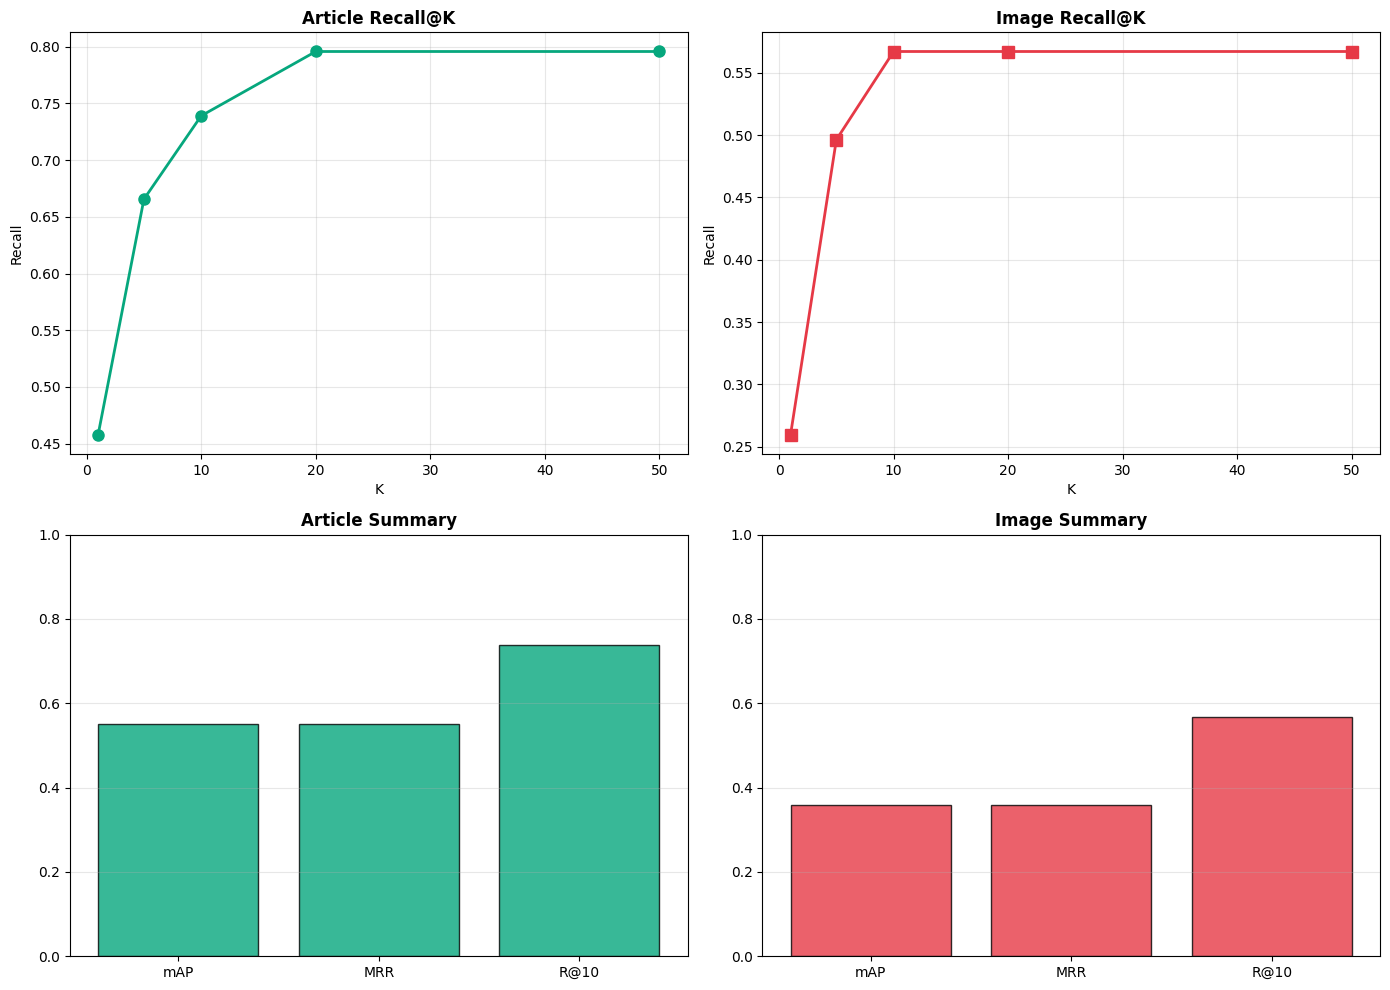

Saved: dual_stage_results.png


In [11]:
print("VISUALIZATION")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

recall_ks = [1, 5, 10, 20, 50]
art_recalls = [article_metrics[f'Article_Recall@{k}'] for k in recall_ks]
img_recalls = [image_metrics[f'Image_Recall@{k}'] for k in recall_ks]

axes[0, 0].plot(recall_ks, art_recalls, marker='o', linewidth=2, markersize=8, color='#06A77D')
axes[0, 0].set_title('Article Recall@K', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(recall_ks, img_recalls, marker='s', linewidth=2, markersize=8, color='#E63946')
axes[0, 1].set_title('Image Recall@K', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].grid(alpha=0.3)

art_summary = ['mAP', 'MRR', 'R@10']
art_vals = [article_metrics['Article_mAP'], article_metrics['Article_MRR'], article_metrics['Article_Recall@10']]
axes[1, 0].bar(art_summary, art_vals, color='#06A77D', alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Article Summary', fontweight='bold', fontsize=12)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(alpha=0.3, axis='y')

img_summary = ['mAP', 'MRR', 'R@10']
img_vals = [image_metrics['Image_mAP'], image_metrics['Image_MRR'], image_metrics['Image_Recall@10']]
axes[1, 1].bar(img_summary, img_vals, color='#E63946', alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Image Summary', fontweight='bold', fontsize=12)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dual_stage_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: dual_stage_results.png")

#  TEST INFERENCE

In [12]:
print("TEST SET INFERENCE WITH RERANKING")

test_df = pd.read_csv(CONFIG.TEST_PUBLIC_CSV)
print(f"Test queries: {len(test_df)}")

caption_col = 'caption' if 'caption' in test_df.columns else test_df.columns[1]
query_id_col = 'query_id' if 'query_id' in test_df.columns else test_df.columns[0]

test_captions = test_df[caption_col].tolist()
test_query_ids = test_df[query_id_col].tolist()

print(f"\nEncoding {len(test_captions)} test queries...")
test_embeddings = generate_embeddings(test_captions, model, CONFIG.BATCH_SIZE)

print("FAISS retrieval...")
test_distances, test_indices = search_index(test_embeddings, index, CONFIG.TOP_K_ARTICLES)

print("Article reranking...")
test_reranked_articles = []
for query, candidate_indices in tqdm(zip(test_captions, test_indices), 
                                     total=len(test_captions),
                                     desc="Reranking test articles"):
    candidate_article_ids = [article_ids[idx] for idx in candidate_indices]
    candidate_texts = [database[aid]['title'] + ' ' + database[aid].get('content', '')[:1000] 
                      for aid in candidate_article_ids]
    reranked_aids = rerank_articles(query, candidate_texts, candidate_article_ids,
                                    article_reranker_tokenizer, article_reranker_model,
                                    CONFIG.DEVICE, CONFIG.RERANK_BATCH_SIZE, 
                                    CONFIG.TOP_K_ARTICLES_RERANK)
    test_reranked_articles.append(reranked_aids)

print("Image reranking...")
test_retrieved_images = []
for query, arts in tqdm(zip(test_captions, test_reranked_articles), 
                       total=len(test_reranked_articles),
                       desc="Test image reranking"):
    candidate_image_ids = []
    for aid in arts:
        candidate_image_ids.extend(article_image_map.get(aid, []))
        if len(candidate_image_ids) >= CONFIG.TOP_K_IMAGES * 3:
            break
    candidate_image_paths = [f"{CONFIG.DATABASE_IMAGE_DIR}/{img_id}.jpg" 
                            for img_id in candidate_image_ids[:CONFIG.TOP_K_IMAGES * 3]]
    if candidate_image_paths:
        reranked_image_paths = rerank_images(query, candidate_image_paths, 
                                            image_reranker_processor, 
                                            image_reranker_model,
                                            CONFIG.DEVICE, CONFIG.TOP_K_IMAGES)
        reranked_image_ids = [os.path.basename(p).replace('.jpg', '') 
                             for p in reranked_image_paths]
    else:
        reranked_image_ids = candidate_image_ids[:CONFIG.TOP_K_IMAGES]
    test_retrieved_images.append(reranked_image_ids[:CONFIG.TOP_K_IMAGES])

print(f"\nTest retrieval with reranking complete")

del test_embeddings
gc.collect()
torch.cuda.empty_cache()

TEST SET INFERENCE WITH RERANKING
Test queries: 3000

Encoding 3000 test queries...


Encoding: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]


FAISS retrieval...
Article reranking...


Reranking test articles: 100%|██████████| 3000/3000 [24:22<00:00,  2.05it/s]


Image reranking...


Test image reranking: 100%|██████████| 3000/3000 [00:00<00:00, 9474.86it/s]



Test retrieval with reranking complete


# SUBMISSION GENERATION

In [18]:
submission_rows = []
for query_id, imgs in tqdm(zip(test_query_ids, test_retrieved_images), 
                          total=len(test_query_ids), 
                          desc="Generating submission"):
    while len(imgs) < CONFIG.TOP_K_IMAGES:
        imgs.append('#')
    row = [query_id] + imgs[:CONFIG.TOP_K_IMAGES]
    submission_rows.append(row)

submission_df = pd.DataFrame(
    submission_rows,
    columns=['query_id', 'image_id_1', 'image_id_2', 'image_id_3', 
             'image_id_4', 'image_id_5', 'image_id_6', 'image_id_7', 
             'image_id_8', 'image_id_9', 'image_id_10']
)
submission_df.to_csv('submission.csv', index=False)
print(f"\nReranked submission file created: submission.csv")

Generating submission:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating submission: 100%|██████████| 3000/3000 [00:00<00:00, 77581.31it/s]


Reranked submission file created: submission.csv


# ZIP CREATION

In [19]:
print("CREATING SUBMISSION ZIP")

import zipfile
import os

if os.path.exists('submission.csv'):
    with zipfile.ZipFile('submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write('submission.csv')
    
    csv_size = os.path.getsize('submission.csv') / 1024
    zip_size = os.path.getsize('submission.zip') / 1024
    
    print(f"Files created:")
    print(f"   submission.csv: {csv_size:.2f} KB")
    print(f"   submission.zip: {zip_size:.2f} KB")
    print(f"   Compression ratio: {(1 - zip_size/csv_size)*100:.1f}%")
    
    print("\n" + "="*80)
    print("SUBMISSION READY")
    print("="*80)
else:
    print("Error: submission.csv not found")


CREATING SUBMISSION ZIP
Files created:
   submission.csv: 547.97 KB
   submission.zip: 217.13 KB
   Compression ratio: 60.4%

SUBMISSION READY
